<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Очистка-и-лемматизация-текста" data-toc-modified-id="Очистка-и-лемматизация-текста-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Очистка и лемматизация текста</a></span></li><li><span><a href="#Частотный-анализ-слов" data-toc-modified-id="Частотный-анализ-слов-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Частотный анализ слов</a></span></li><li><span><a href="#Добавление-новых-признаков" data-toc-modified-id="Добавление-новых-признаков-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Добавление новых признаков</a></span></li><li><span><a href="#Разделение-выборки-на-части" data-toc-modified-id="Разделение-выборки-на-части-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Разделение выборки на части</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LogisticRegression" data-toc-modified-id="LogisticRegression-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LogisticRegression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="Итоговый-вывод-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Итоговый вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

Сделаем необходимые импорты.

In [3]:
!pip install wordcloud

In [4]:
import pandas as pd
import numpy as np
import re 
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.probability import FreqDist

from wordcloud import WordCloud

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

from catboost import CatBoostClassifier

from lightgbm import LGBMClassifier

from sklearn.metrics import f1_score

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Загрузим имеющийся датасет.

In [5]:
try:
    data = pd.read_csv(r'C:\Users\Марина\Downloads\toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv', index_col=0)

### Исследовательский анализ данных

Посмотрим на основные параметры. 

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Проверим наличие пропусков.

In [7]:
data.isna().sum()

text     0
toxic    0
dtype: int64

In [8]:
data.sample(10)

,text,toxic
20883,"""\n\nIf you can show me a """"Phd."""" scholar fro...",0
31153,The fact that you have indicated you are the a...,0
42094,2014 (UTC)\n I object to this. It's not a cale...,0
100226,Unsourced entries \n\nIn accordance with BLP p...,0
158813,Administratore: I need your help to stop DIREK...,1
140733,The Six Feet Under logo could do with a transp...,0
113347,"""\n\nPlease note that another Wikipedia articl...",0
150441,Serious redundancy issues \n\nThere is substan...,0
112587,"""\n\n A barnstar for you! \n\n The Teamwork B...",0
130651,"""\nToa and Jerzeykydd have gone to great lengt...",0


Проверим наличие дубликатов.

In [9]:
data.duplicated().sum()

0

Посмотрим на распредение данных по целевому признаку.

In [10]:
data['toxic'].value_counts(normalize= True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

Присутствует дисбаланс классов по целевому признаку. В дальнейшем будем использовать параметр для весов классов в моделях.

### Очистка и лемматизация текста

Очистим и лемматизируем текст комментариев.

In [11]:
#функция очистки текста
def clear_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = re.sub(r'\b(\w{100,})\b', ' ', text) #убираем очень длинные слова (более 100 символов), их невозможно лемматизировать
    text = text.split()
    text = " ".join(text)
    return text

In [12]:
data['cleared_text'] = data['text'].apply(clear_text)

In [13]:
data.head()

,text,toxic,cleared_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...


In [14]:
# лемматизация текста
lemmatizer = WordNetLemmatizer()

wordnet_map ={"N": wordnet.NOUN,
             "V": wordnet.VERB,
             "J": wordnet.ADJ,
             "R": wordnet.ADV}

# лемматизируем слово в зависимости от части речи, которым оно является
# если в слове нет такой части речи, то по умолчанию принимаем за существительное

def lemmatize(text):
    text_with_pos_tag = pos_tag(text.split())
    return " ".join([lemmatizer.lemmatize(word, wordnet_map.get(pos[0],wordnet.NOUN)) for word, pos in text_with_pos_tag])


In [15]:
%%time

tqdm.pandas()

data['lemm_text'] = data['cleared_text'].progress_apply(lemmatize)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 8min 31s, sys: 7.72 s, total: 8min 38s
Wall time: 8min 53s


In [16]:
data.head()

,text,toxic,cleared_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


In [17]:
#очистка текста от стоп-слов

stopwords = set(stopwords.words('english'))

def delete_stopwords(text):
    text = " ".join([word for word in text.split() if word not in stopwords])
    return text

In [18]:
data['lemm_text_wo_stop'] = data['lemm_text'].apply(delete_stopwords)
data.head()

,text,toxic,cleared_text,lemm_text,lemm_text_wo_stop
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits make under my userna...,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour i m seem...,aww match background colour seemingly stick th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man i m really not try to edit war it s ju...,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...,sir hero chance remember page


### Частотный анализ слов

Создадим облако слов для понимания наиболее часто встречающихся слов в комментариях.

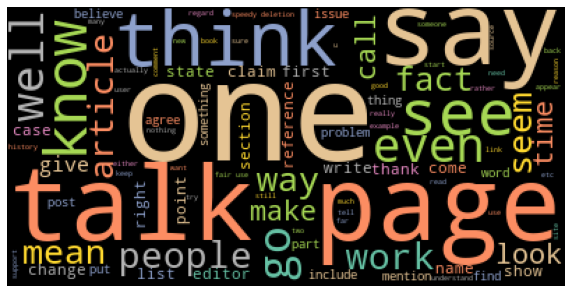

In [19]:
wordcloud = WordCloud(colormap= 'Set2', max_words = 90).generate(" ".join(data['lemm_text_wo_stop']))
plt.figure(figsize = (10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Проведем частотный анализ текста для первых 60 наиболее часто встречающихся слов в комментариях.

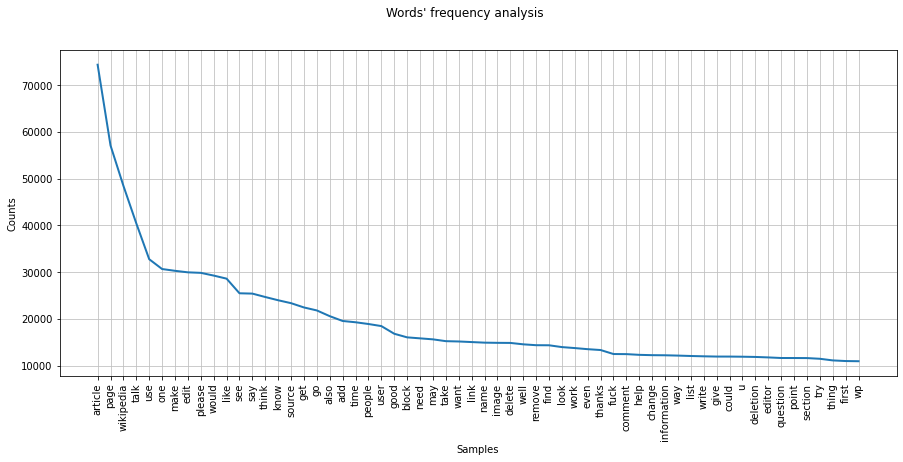

In [20]:
from nltk import word_tokenize
text_tokens = word_tokenize(" ".join(data['lemm_text_wo_stop']))
text = nltk.Text(text_tokens)
fdist = FreqDist(text)
plt.figure(figsize=(15,6))
plt.suptitle("Words' frequency analysis")
fdist.plot(60,cumulative=False)
plt.show()

Частотный анализ текста и облако слов наглядно демонстрируют факт того, что большинство комментариев имеют 
позитивный нетоксичный характер.

### Добавление новых признаков

Добавим новые признаки:
    
    - lenght: общее количество символов в комментарии
    - noun: количество существительных в комментарии
    - verb: количество глаголов в комментарии
    - adj: количество прилагательных в комментарии
    - adv: количество наречий в комментарии
    - other: количество остальных частей речи в комментарии
    - words_ number: количество слов в комментарии

In [21]:
#общее количество символов в комментарии
    
data['lenght'] = data['cleared_text'].apply(len)

In [22]:
# функция подсчета частей речи в тексте
def part(text):
    text_with_pos_tag = pos_tag(text.split())
    noun =0
    verb =0
    adj=0
    adv =0
    other =0
    for word, pos in text_with_pos_tag:
        if pos[0] == 'N':
            noun += 1
        elif pos[0] == 'V':
            verb += 1
        elif pos[0] == 'J':
            adj += 1
        elif pos[0] == 'R':
            adv += 1 
        else:
            other +=1
    return noun, verb, adj, adv, other

In [23]:
tqdm.pandas()
data['list'] = data['cleared_text'].progress_apply(part)

  0%|          | 0/159292 [00:00<?, ?it/s]

In [24]:
data['noun'] = data['list'].str[0]
data['verb'] = data['list'].str[1]
data['adj'] = data['list'].str[2]
data['adv'] = data['list'].str[3]
data['other'] = data['list'].str[4]

In [25]:
data = data.drop(['list'], axis=1)

In [26]:
# функция подсчета числа слов в тексте
def words_number(text):
    text = text.split()
    words_number = len(text)
    return words_number

data['words_number'] = data['cleared_text'].apply(words_number)

In [27]:
data.head()

,text,toxic,cleared_text,lemm_text,lemm_text_wo_stop,lenght,noun,verb,adj,adv,other,words_number
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits make under my userna...,explanation edits make username hardcore metal...,248,17,8,5,2,14,46
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour i m seem...,aww match background colour seemingly stick th...,88,6,4,1,1,4,16
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man i m really not try to edit war it s ju...,hey man really try edit war guy constantly rem...,229,10,10,2,6,16,44
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...,make real suggestion improvement wonder sectio...,601,31,23,7,9,46,116
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...,sir hero chance remember page,63,3,4,0,0,7,14


In [28]:
data = data.drop(['text', 'cleared_text', 'lemm_text'], axis=1)

### Разделение выборки на части

Выделим признаки и целевой показатель. Разделим выборку на обучающую и тестовую в соотношении 75% : 25% соответственно.

In [29]:
features = data.drop(['toxic'], axis=1)
target = data['toxic']

features_train,features_test, target_train, target_test = train_test_split (features, target, \
                                                                    test_size = 0.25, random_state = 123, stratify = target)

<b> ВЫВОД: </b> 
На первоначальном этапе исследования выполнены следующие шаги:
- проведен первичный анализ имеющихся данных
- осуществлена предобработка выборки: проверка наличия пропусков, неинформативных данных и явных дубликатов
- проведена очистка и лемматизация текста, а также удаление стоп-слов
- выделены признаки и целевой показатель, выборка разделена на обучающую и тестовую части.

Сделаны следующие значимые выводы:
- целевой показатель - бинарная качественная переменная, соответсвенно перед нами стоит задача бинарной классификации
- присутствует дисбаланс данных по целевому признаку, это нужно учесть при моделировании
- в данных нет пропусков и дубликатов

Выборка готова к моделированию.

## Обучение

Обучим три модели классификации:
   - LogisticRegression
   - CatBoostClassifier
   - LightGBMClassifier

Поскольку целевой признак несбалансирован по классам, будем использовать параметр для балансировки методом взвешивания классов.
Подберем гиперпараметры, все полученнные результаты по лучшим моделям запомним с целью дальнейшего сравнения и выбора наилучшей.

### LogisticRegression

In [30]:
%%time


new_features = ['lenght', 'noun', 'verb', 'adj', 'adv', 'other', 'words_number']

transformer_lr = make_column_transformer(
                   (TfidfVectorizer(ngram_range=(1, 2), max_df = 0.9, min_df = 2), "lemm_text_wo_stop"),
                   (StandardScaler(), new_features))

pipe = Pipeline([('features_all_prepross', transformer_lr),
                 ('clf', LogisticRegression(class_weight ='balanced', random_state = 42))
                ])


param_grid = {'clf__C': [1, 10],
             'clf__max_iter' : [250, 350]}

grid_lr = GridSearchCV(pipe, param_grid, cv=3, scoring='f1', n_jobs = -1)
grid_lr.fit(features_train, target_train)

lr_model_best = grid_lr.best_estimator_

print('Наилучшая модель LogisticRegression:', grid_lr.best_params_)
print(f'F-1_LogisticRegression = {grid_lr.best_score_}')

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Наилучшая модель LogisticRegression: {'clf__C': 10, 'clf__max_iter': 250}
F-1_LogisticRegression = 0.77348117106659
CPU times: user 23min 7s, sys: 22min 26s, total: 45min 34s
Wall time: 45min 37s


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<div class="alert alert-block alert-info">
<font size="4"><b> Комментарий студента </b></font> :
 Спасибо за подсказку. Добавила новые фичи, а также перебор биграмм в tf-idf в логистическую регрессию, удалось немного улучшить метрику 
качества по сравнению с прошлым разом (примерно на 0.03)
</div>

### CatBoost

In [31]:
%%time

transformer_cb = make_column_transformer((TfidfVectorizer(max_df = 0.9, min_df = 2), \
                                            "lemm_text_wo_stop"))

pipe_cb = Pipeline([('features_prepross', transformer_cb), 
                 ('clf', CatBoostClassifier(random_state = 123, silent=True))])

param_grid =  {'clf__learning_rate': [0.1, 0.5],
              'clf__n_estimators': [70, 110]}

cb = GridSearchCV(pipe_cb, param_grid, scoring = 'f1', cv=3, n_jobs = -1, verbose=2)
cb.fit(features_train, target_train)
cb_best =  cb.best_estimator_

print('Наилучшая модель CatBoost:', cb.best_params_)
print(f'F1_cat_boost = {cb.best_score_}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .......clf__learning_rate=0.1, clf__n_estimators=70; total time= 1.8min
[CV] END .......clf__learning_rate=0.1, clf__n_estimators=70; total time= 1.8min
[CV] END .......clf__learning_rate=0.1, clf__n_estimators=70; total time= 1.8min
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=110; total time= 2.7min
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=110; total time= 2.7min
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=110; total time= 2.7min
[CV] END .......clf__learning_rate=0.5, clf__n_estimators=70; total time= 1.7min
[CV] END .......clf__learning_rate=0.5, clf__n_estimators=70; total time= 1.8min
[CV] END .......clf__learning_rate=0.5, clf__n_estimators=70; total time= 1.8min
[CV] END ......clf__learning_rate=0.5, clf__n_estimators=110; total time= 2.6min
[CV] END ......clf__learning_rate=0.5, clf__n_estimators=110; total time= 2.6min
[CV] END ......clf__learning_rate=0.5, clf__n_est

### LightGBM

In [32]:
%%time

model_lgbm = LGBMClassifier(random_state = 123)

transformer_lgbm = make_column_transformer((TfidfVectorizer(max_df = 0.9, min_df = 2), \
                                            "lemm_text_wo_stop"))

pipe_lgbm = Pipeline([('features_prepross', transformer_lgbm), 
                 ('clf', LGBMClassifier(random_state = 123))])

params = { 'clf__learning_rate': [0.1, 0.3],
           'clf__n_estimators': [70, 110]}

lgbm  = GridSearchCV(pipe_lgbm, params, cv=3, scoring='f1',n_jobs = -1, verbose = 2)
lgbm.fit(features_train, target_train)
lgbm_best = lgbm.best_estimator_

print('Наилучшая модель LightGBM:', lgbm.best_params_)
print(f'F1_lgbm = {lgbm.best_score_}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .......clf__learning_rate=0.1, clf__n_estimators=70; total time= 3.7min
[CV] END .......clf__learning_rate=0.1, clf__n_estimators=70; total time= 2.5min
[CV] END .......clf__learning_rate=0.1, clf__n_estimators=70; total time= 1.8min
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=110; total time= 5.0min
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=110; total time= 2.3min
[CV] END ......clf__learning_rate=0.1, clf__n_estimators=110; total time= 2.3min
[CV] END .......clf__learning_rate=0.3, clf__n_estimators=70; total time= 1.5min
[CV] END .......clf__learning_rate=0.3, clf__n_estimators=70; total time= 1.5min
[CV] END .......clf__learning_rate=0.3, clf__n_estimators=70; total time= 1.5min
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=110; total time= 2.1min
[CV] END ......clf__learning_rate=0.3, clf__n_estimators=110; total time= 2.1min
[CV] END ......clf__learning_rate=0.3, clf__n_est

Выберем наилучшую модель, основываясь на метрику F1_score.

In [33]:
results = pd.DataFrame({'Model': ['LogisticRegression', 'CatBoostClassifier', 'LightGBMClassifier'], \
                       'F1_score': [grid_lr.best_score_, cb.best_score_, lgbm.best_score_]})
display(results)

,Model,F1_score
0,LogisticRegression,0.773481
1,CatBoostClassifier,0.732375
2,LightGBMClassifier,0.761616


Наилучшей оказалось модель LightGBMClassifier. Проведем проверку на тестовой выборке.

In [34]:
lr_model_best.fit(features_train, target_train)
predictions = lr_model_best.predict(features_test)
f1_score_test = f1_score(target_test, predictions)
print(f1_score_test)

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7842761265580058


Показатель метрики F1 > 0.75. Удалось достичь необходимого результата. Построенная модель адекватна поставленной задаче.

<b> ВЫВОД: </b> 
На данном этапе проведено моделирование с использованием трех типов моделей:
  - LogisticRegression
  - CatBoostClassifier
  - LightGBMClassifier

Для каждой модели осуществлен поиск гиперпараметов, найдена наилучшая модель каждого типа по метрике качества F1_score.
Затем проведено сравнение наилучших моделей и выбрана конечная модель с наивысшим показателем F1 метрики.
Ей оказалось LogisticRegression. 

Выбранная модель была проверена на тестовой выборке. Она показала результат F1-метрики > 0.75, что является адекватным поставленной задаче результатом.

## Итоговый вывод

   Целью данного проекта было создать модель бинарной классификации с целью выявления токсичных комментариев пользователей 
интернет-магазина и отправления их на последующую модерацию.

   Модели сравнивали по метрике качества F1, необходимо было превысить пороговый уровень в 0,75.

   В ходе проекта исходные данные были исследованы и предобработаны. Основным этапом подготовки даннных к моделированию 
стали очистка текста, его лемматизация и исключение стоп-слов.

   Затем были обучены три модели классификации. В ходе обучения исходные данные были преобразованы в TF-IDF матрицу, 
затем проведено моделирование при использовании различных классификаторов, и вычислена метрика качества.

   На завершающем этапе наилучшая по метрике F1 модель проверена на тестовых данных. Ей оказалось модель LogisticRegression. 
Модель показала хороший результат и на тестовой выборке, он оказался больше 0,75.

   Поставленная цель была достигнута. Разработана модель бинарной классификации, адекватная предоставленным данным.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны